In [1]:
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt

---
# Task1

Запрограммировать формулу точной цены барьерного up-and-out call и сравнить с точным решением европейского call при барьере $B\to\infty$, $B\to K$, $B=2K$, $B=10K$, где К - страйк.

$v(t, x) = x[N(\delta_{+}(\tau, \frac{x}{K})) - N(\delta_{+}(\tau, \frac{x}{B}))] - e^{-r\tau}K[N(\delta_{-}(\tau, \frac{x}{K})) - N(\delta_{-}(\tau, \frac{x}{B}))] - B(\frac{x}{B})^{-\frac{2r}{\sigma^2}}[N(\delta_{+}(\tau, \frac{B^2}{Kx})) - N(\delta_{+}(\tau, \frac{B}{x}))]+e^{-r\tau}K(\frac{x}{B})^{-\frac{2r}{\sigma^2}+1}[N(\delta_{-}(\tau, \frac{B^2}{Kx})) - N(\delta_{-}(\tau, \frac{B}{x}))]$ <br>

$0\leq t < T$, $0< x \leq B$ <br>

$N(x)=\frac{1}{\sqrt{2\pi}}\int_{-\infty}^xe^{-\frac{y^2}{2}}dy$ - функция нормального распределения <br>

$\delta_{\pm}(\tau, s) = \frac{1}{\sigma\sqrt{\tau}}[\log{s} + (r \pm \frac{1}{2}\sigma^2)\tau]$

Europian call : $c(t,S(t)) = S(t)\Phi(\alpha_{+})-Ke^{-rt}\Phi(\alpha_{-})$

$\alpha_{\pm}=\frac{1}{\sigma\sqrt{\tau}}[\ln{\frac{S(t)}{K}} + (r\pm\frac{\sigma^2}{2})\tau]$

In [113]:
T = 1
B = 100
K = 78
S0 = 50

STEPS = 100

_times = np.linspace(0, T, STEPS+1)
tau = T - _times[:-1]
S = np.linspace(0, 1.3*B, STEPS)

def delta_pl(tau, s, r, sigma):
    return (np.log(s) + (r + sigma**2 / 2) * tau) / sigma / np.sqrt(tau)

def delta_ms(tau, s, r, sigma):
    return (np.log(s) + (r - sigma**2 / 2) * tau) / sigma / np.sqrt(tau)

def  barrier_up_and_out_call(S, K, B, r, sigma, tau):
    term1 = S * (norm.cdf(delta_pl(tau, S / K, r, sigma)) - norm.cdf(delta_pl(tau, S / B, r, sigma)))
    term2 = -np.exp(-r * tau) * K * \
        (norm.cdf(delta_ms(tau, S / K, r, sigma)) - norm.cdf(delta_ms(tau, S / B, r, sigma)))
    term3 = -B * (S / B) ** (- 2 * r / sigma**2) * \
        (norm.cdf(delta_pl(tau, B**2 / (K * S), r, sigma)) - norm.cdf(delta_pl(tau, B / S, r, sigma)))
    term4 = np.exp(-r * tau) * K * (S / B) ** (- 2 * r / sigma**2 + 1) * \
        (norm.cdf(delta_ms(tau, B**2 / (S * K), r, sigma)) - norm.cdf(delta_pl(tau, B / S, r, sigma)))
    return np.where(S < B, term1 + term2 + term3 + term4, 0)


def europian_call(S, K, r, sigma, tau):
    return S * norm.cdf(delta_pl(tau, S / K, r, sigma)) - \
        K * np.exp(-r * tau) * norm.cdf(delta_ms(tau, S / K, r, sigma))

In [154]:
def plot_europian_and_up_and_out_calls(S0, T, Bs, K, STEPS, r, sigma):
    _times = np.linspace(0, T, STEPS+1)
    tau = T - _times[:-1]

    ncols = 2
    nrows = len(Bs) // 2 + len(Bs) % 2

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(nrows*6, ncols*4))

    for idx, B in enumerate(Bs):

        S = np.linspace(S0, 2*K, STEPS)
        
        up_and_out_call = barrier_up_and_out_call(S, K, B, r, sigma, tau)
        euro_call = europian_call(S, K, r, sigma, tau)

        axs[idx // 2, idx % 2].plot(_times[:-1], up_and_out_call, label='Up-and-out call')
        axs[idx // 2, idx % 2].plot(_times[:-1], euro_call, label='Euro call')
        axs[idx // 2, idx % 2].plot(_times[:-1], np.ones_like(euro_call) * K, label='K')
        # axs[idx // 2, idx % 2].plot(_times[:-1], np.ones_like(euro_call) * B, label='B')
        axs[idx // 2, idx % 2].plot(_times[:-1], S, label='S')
        
        axs[idx // 2, idx % 2].set_title(f'K = {K}, B = {B}')
        axs[idx // 2, idx % 2].set_xlabel('Time')
        axs[idx // 2, idx % 2].set_ylabel('option price')
        axs[idx // 2, idx % 2].legend()
    plt.tight_layout()
    plt.show()

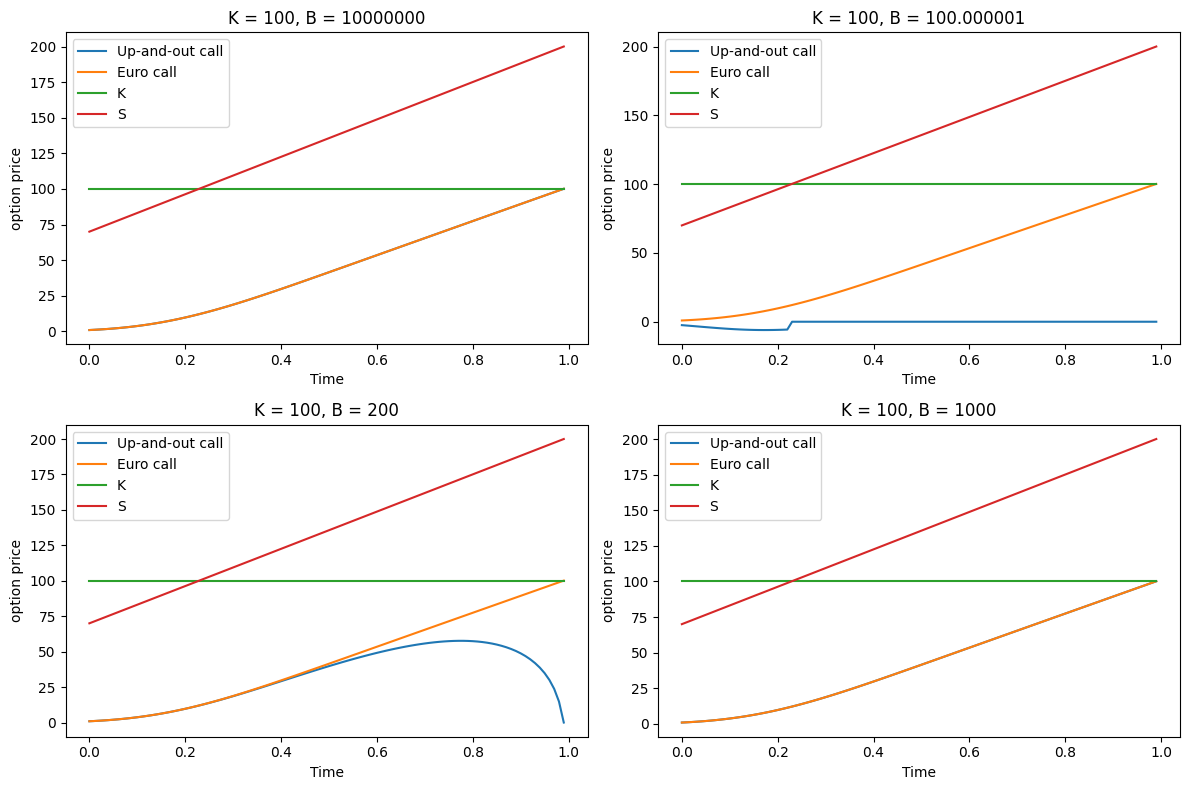

In [156]:
T = 1
K = 100
B = [K * 10**5, K+1e-6, 2 * K, 10 * K]
S0 = 70

STEPS = 100
R = 0.12
SIGMA = 0.2

plot_europian_and_up_and_out_calls(S0, T, B, K, STEPS, R, SIGMA)

---
# Task2

Найти цену барьерного <b>up-and-out call</b> методом <b>Монте Карло</b> и сравнить с точной ценой. Задача засчитывается, если относительная погрешность будет не более <b>$10^{-3}$</b> (среднее на неескольких запусках.)

BSM equation for Up-and-Out option:

$rv(t,x)=v_t(t,x)+rxv_x(t,x)+\frac{1}{2}\sigma^2x^2v_{xx}(t,x)$

in the rectangle: {$(t,x):\ 0\leq t < T,\ 0\leq x\leq B$}

with the boundary conditions:

1. $v(t,0)=0$, $0\leq t < T$,
2. $v(t,B)=0$, $0\leq t < T$,
3. $v(T,x)=(x-K)_{+}$, $0\leq x \leq B$

---
# Task3

Решить численно уравнение Блэка-Шоулза для барьерного <b>up-and-out call</b> и сравнить с точной ценой. Задача засчитывается, если относительная погрешность будет не более 0.01 для почти всех узов сетки.

---
# Task4

Запрограммировать формулу цены <b>lookback</b> опциона с переменным страйком после понижения размерности. Нарисовать ее график по $z=\frac{x}{y}$

$u(t,z)=(1 + \frac{\sigma^2}{2r})zN(\delta_{+}(\tau, z)) + e^{-r\tau}N(-\delta_{-}(\tau, z)) - \frac{\sigma^2}{2r}e^{-r\tau}z^{1-\frac{2r}{\sigma^2}}N(-\delta_{-}(\tau, z^{-1})) - z$, $0\leq t < T,\ 0 < z \leq 1$

In [150]:
def price_lookback_option(tau, z, r, sigma):
    term1 = (1 + sigma**2 / 2 / r) * z * norm.cdf(delta_pl(tau, z, r, sigma))
    term2 = np.exp(-r * tau) * norm.cdf(-delta_ms(tau, z, r, sigma))
    term3 = - sigma**2 / 2 / r * np.exp(-r * tau) * z ** (1 - 2 * r / sigma**2) * \
        norm.cdf(-delta_ms(tau, 1 / z, r, sigma))
    # print(term1, term2, term3)
    return term1 + term2 + term3 - z 

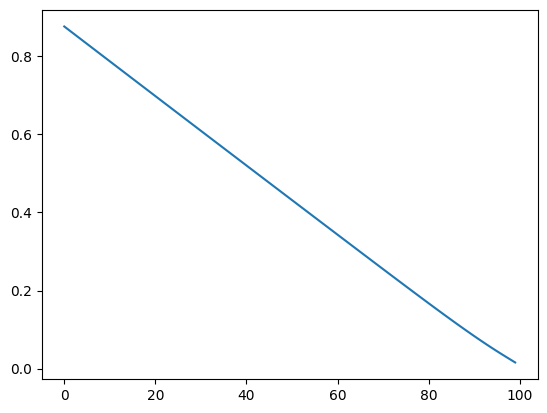

In [151]:
_time = np.linspace(0, 1, 101)
tau = 1 - _time[:-1]
z = np.linspace(0.01, 1, 100)

plt.plot(price_lookback_option(tau, z, 0.12, 0.2))

---
# Task 5

Решиль аналогичную задачу 2.2 для <b>lockback</b> опциона с переменным страйком после понижения размерности.

BSM equation for the Lookback option:

$ru(t,z)=u_t(t,z)+rzu_z(t,z)+\frac{1}{2}\sigma^2z^2u_{zz}(t,z)$

with the following boundary conditions:

1. $u(t,0)=e^{-r(T-t)}$, $0\leq t \leq T$
2. $u(t,1)=u_z(t,1)$, $0\leq t < T$
3. $u(T,z)=1-z$, $0\leq z \leq 1$

--- 
# Task6

Решиль аналогичную задачу 2.3 для <b>lockback</b> опциона с переменным страйком после понижения размерности.